<a href="https://colab.research.google.com/github/arghasree/RL/blob/main/coin_flip_MDP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch

In [3]:
# Initialize: gamma, threshold, states, actions, reward
gamma = 1
threshold = 1e-10
n_states = 101

rewards = torch.zeros(n_states)
rewards[-1] = 1 # Only at state 100, the reward is 1, otherwise it is 0

Why is the discount factor 1?
- This is also called an undiscounted MDP
- Why is the discount factor less than 1? This happens when the event end is at infinity. But in this case the game ends when the state is 0 or 100+.
- So discount factor 1 is a valid option
- The second reason is that immediate reward is always 0
- A reward is only received when the game is won (state = 100+)
- Therefore all the future rewards must be considered without any further discount.  

Why is the number of states 101?
- 100 - 0 + 1 = 101 states including 0 and 100


In [4]:
# Defining env as a custom dictionary
env = {
    'max_capital' : 100,
    'head_prob' : 0.40,
    'rewards' : rewards,
    'gamma' : gamma,
    'threshold' : threshold,
    'n_states' : n_states
}

Now use the value iteration algorithm to extract the optimal policy

# Recall VI:


- VI is slower because it first calculates the optimal values of each state and then extracts the optimal policy.
- VI has 2 steps:
  - The optimal values of each states are calculated
  - The optimal policy is extracted
- Optimal value of each state:
$$V = max_a \{  ∑_{s'} P(s,a,s')[R(s,a)+ \gamma V(s') ]\}$$



In [33]:
def value_iteration(env):
  max_capital = env['max_capital']
  head_prob = env['head_prob']
  rewards = env['rewards']
  gamma = env['gamma']
  threshold = env['threshold']
  n_states = env['n_states']

  # Initialize the value function
  V = torch.zeros(n_states)

  # For each state, each action is considered.
  # Here action = 0, 1, ... min(s, 100-s)
  while True:
    for state_id in range(1, n_states-1): # Excluding the terminal state
      V_action=[]
      V_temp=V.clone()
      for action_id in range(min(state_id, max_capital - state_id)+1):
        # Each action can produce state s+a if they win, or s-a if they lose
        V_action.append(head_prob*(rewards[state_id+action_id] + gamma * V[state_id+action_id]) +  # if they win
                        (1 - head_prob) * (rewards[state_id-action_id] + gamma * V[state_id-action_id])) # if they lose
      V[state_id] = max(V_action)
    if torch.max(torch.abs(V - V_temp)) <= threshold:
      break
  return V

How to extract the optimal policy?
- Recall
- For each state, store an action
- For each state, calculate the values of each state for all actions, and then store the action for which the value of the state is maximum.
- The value of each state is calculated as:
$$V =   ∑_{s'} P(s,a,s')[R(s,a)+ \gamma V(s') ]$$

In [34]:
def extract_optimal_policy(env, V):
  max_capital = env['max_capital']
  head_prob = env['head_prob']
  rewards = env['rewards']
  gamma = env['gamma']
  n_states = env['n_states']

  pi = torch.zeros(n_states)
  for state_id in range(1, n_states-1):
    Q=[]
    for action_id in range(min(state_id, max_capital - state_id)+1):
      Q.append(head_prob*(rewards[state_id+action_id] + gamma * V[state_id+action_id]) +
                        (1 - head_prob) * (rewards[state_id-action_id] + gamma * V[state_id-action_id]))
    Q=torch.Tensor(Q)
    pi[state_id] = torch.argmax(Q)

  return pi


In [35]:
import time
start_time = time.time()
V_optimal = value_iteration(env)
optimal_policy = extract_optimal_policy(env, V_optimal)
print("It takes {:.3f}s to solve with value iteration".format(time.time() - start_time))

It takes 1.031s to solve with value iteration


In [36]:
print('Optimal values:\n{}'.format(V_optimal))
print('Optimal policy:\n{}'.format(optimal_policy))

Optimal values:
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0256, 0.0256,
        0.0256, 0.0410, 0.0502, 0.0557, 0.0640, 0.0640, 0.0711, 0.0794, 0.0856,
        0.0941, 0.1024, 0.1066, 0.1154, 0.1254, 0.1332, 0.1439, 0.1600, 0.1600,
        0.1615, 0.1724, 0.1763, 0.1846, 0.1936, 0.1984, 0.2076, 0.2165, 0.2240,
        0.2353, 0.2464, 0.2560, 0.2634, 0.2707, 0.2790, 0.2899, 0.3012, 0.3136,
        0.3224, 0.3339, 0.3482, 0.3604, 0.3762, 0.4000, 0.4000, 0.4015, 0.4124,
        0.4163, 0.4246, 0.4336, 0.4384, 0.4476, 0.4565, 0.4640, 0.4753, 0.4864,
        0.4960, 0.5034, 0.5107, 0.5190, 0.5299, 0.5412, 0.5536, 0.5624, 0.5739,
        0.5882, 0.6004, 0.6162, 0.6400, 0.6413, 0.6498, 0.6602, 0.6686, 0.6784,
        0.6918, 0.7021, 0.7114, 0.7247, 0.7375, 0.7529, 0.7697, 0.7848, 0.7961,
        0.8070, 0.8212, 0.8348, 0.8517, 0.8709, 0.8842, 0.9009, 0.9225, 0.9405,
        0.9643, 0.0000])
Optimal policy:
tensor([ 0.,  0.,  0.,  0.,  3.,  5.,  6.,  0.,  8.,  9., 10., 

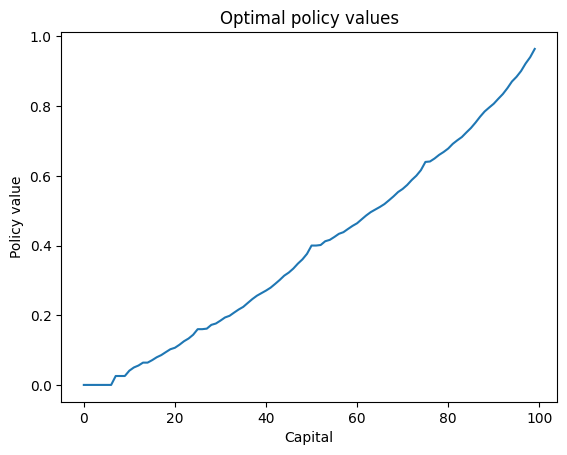

In [37]:
import matplotlib.pyplot as plt
plt.plot(V_optimal[:100].numpy())
plt.title('Optimal policy values')
plt.xlabel('Capital')
plt.ylabel('Policy value')
plt.show()

This plot shows that the value of more money is more. \
What this plot does not show is when/ at which iteration, more money should be played.

# Recall PI:
- Here there is a loop between policy evaluation and policy improvement
